<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Gaussian elimination

## Contents

In this notebook, we will learn

- How to parallelize Gaussian elimination
- How to fix static load imbalance

<div class="alert alert-block alert-info">
<b>Note:</b> Do not forget to execute the cell below before starting this notebook! 
</div>

In [18]:
using Printf
function answer_checker(answer,solution)
    if answer == solution
        "🥳 Well done! "
    else
        "It's not correct. Keep trying! 💪"
    end |> println
end
function ge_par_why()
    msg = "The outer loop of the algorithm is not parallelizable, since the iterations depend on the results of the previous iterations. However, we can extract parallelism from the inner loops."
    println(msg)
end
ge_par_check(answer) = answer_checker(answer, "a")
ge_dep_check(answer) = answer_checker(answer, "b")
function ge_lb_answer()
    msg = "It is a form of static load balancing. We know in advance the load distribution and the partition strategy does not depend on the actual values of the input matrix"
    println(msg)
end

ge_lb_answer (generic function with 1 method)

## Gaussian elimination


[Gaussian elimination](https://en.wikipedia.org/wiki/Gaussian_elimination) is a method to solve systems of linear equations, like this one:

$$
\left[
\begin{matrix}
1 & 3 & 1 \\
1 & 2 & -1 \\
3 & 11 & 5 \\
\end{matrix}
\right]
\left[
\begin{matrix}
x \\
y \\
z  \\
\end{matrix}
\right]
=
\left[
\begin{matrix}
9 \\
1 \\
35  \\
\end{matrix}
\right]
$$

This is just a small example with three unknowns, but practical applications need to solve linear equations with large number of unknowns. Parallel processing is needed in these cases.

### Problem statement

Let us consider a system of linear equations written in matrix form $Ax=b$, where A is a nonsingular square matrix, and x and b are vectors. The goal of Gaussian elimination is to transform the system $Ax=b$, into a new system $Ux=c$ such that
- both system have the same solution vector $x$,
- the matrix $U$ of the new system is *upper triangular* with unit diagonal, namely $U_{ii} = 1$ and $U_{ij} = 0$ for $i>j$.


For the particular system shown above, the transformed one is the following:

$$
\left[
\begin{matrix}
1 & 3 & 1 \\
1 & 2 & -1 \\
3 & 11 & 5 \\
\end{matrix}
\right]
\left[
\begin{matrix}
x \\
y \\
z  \\
\end{matrix}
\right]
=
\left[
\begin{matrix}
9 \\
1 \\
35  \\
\end{matrix}
\right]
\longrightarrow
\left[
\begin{matrix}
1 & 3 & 1 \\
0 & 1 & 2 \\
0 & 0 & 1 \\
\end{matrix}
\right]
\left[
\begin{matrix}
x \\
y \\
z  \\
\end{matrix}
\right]
=
\left[
\begin{matrix}
9 \\
8 \\
4  \\
\end{matrix}
\right]
$$

The most challenging part of solving a system of linear equations is to transform it to upper triangular form. Afterwards, the solution vector can be obtained easily with a backward substitution.



### Augmented system matrix

In practice, vector $b$ is added as an additional column to A forming the so-called *augmented* matrix $A^* = [A | b]$.

$$
\left[
\begin{matrix}
1 & 3 & 1 \\
1 & 2 & -1 \\
3 & 11 & 5 \\
\end{matrix}
\right]
\left[
\begin{matrix}
x \\
y \\
z  \\
\end{matrix}
\right]
=
\left[
\begin{matrix}
9 \\
1 \\
35  \\
\end{matrix}
\right]\longrightarrow
A^*=
\left[
\begin{matrix}
1 & 3 & 1 & 9  \\
1 & 2 & -1 & 1 \\
3 & 11 & 5 & 35\\
\end{matrix}
\right]
$$

With this new notation, the goal of Gaussian elimination is to find the augmented matrix containing $U$ and $c$, namely $U^*= [U | c]$, given the augmented matrix $A^* = [A | b]$.

$$
A^*=
\left[
\begin{matrix}
1 & 3 & 1 & 9  \\
1 & 2 & -1 & 1 \\
3 & 11 & 5 & 35\\
\end{matrix}
\right]\longrightarrow
U^*=
\left[
\begin{matrix}
1 & 3 & 1 & 9 \\
0 & 1 & 2 & 8\\
0 & 0 & 1 & 4\\
\end{matrix}
\right]
$$



### Serial implementation


The following algorithm computes the Gaussian elimination on a given augmented matrix `B`, representing a system of linear equations.

- The outer loop is a loop over rows.
- The first inner loop in line 4 divides the current row by the value of the diagonal entry, thus transforming the diagonal to contain only ones. Note that we skip the first entries in the row, as we know that these values are zero at this point. The cells updated in this loop at iteration $k$ are depicted in red in the figure below.
- The second inner loop beginning in line 8 substracts the rows from one another such that all entries below the diagonal become zero. The entries updated in this loop are depicted in blue in the figure below.

In [13]:
function gaussian_elimination!(B)
    n,m = size(B)
    @inbounds for k in 1:n
        for t in k:m
            B[k,t] =  B[k,t]/B[k,k]
        end
        for i in (k+1):n 
            for j in k:m
                B[i,j] = B[i,j] - B[i,k]*B[k,j]
            end
        end
    end
    B
end

gaussian_elimination! (generic function with 1 method)

<div>
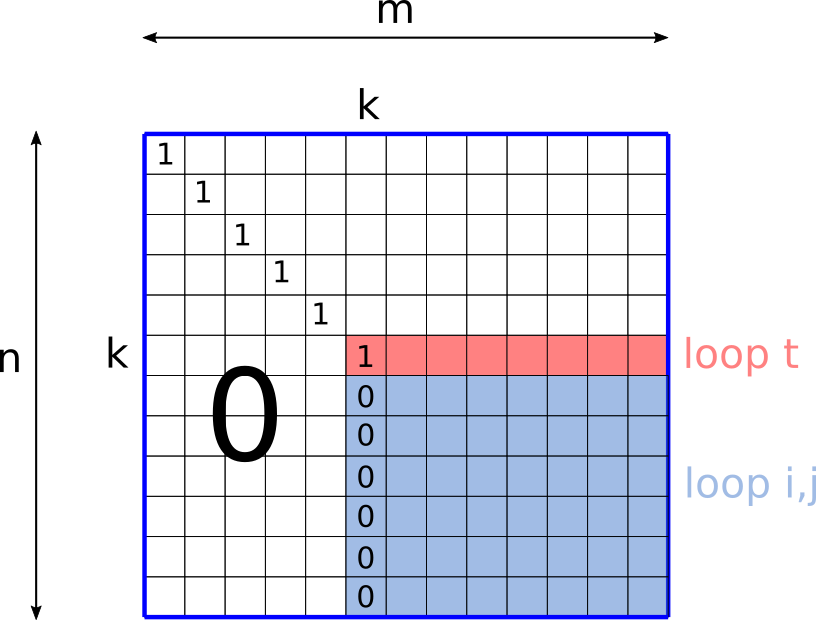
</div>


<div class="alert alert-block alert-info">
<b>Note:</b> This algorithm is not correct for all matrices: if any diagonal element <code>B[k,k]</code> is zero, the computation in the first inner loop fails. To get around this problem, another step can be added to the algorithm that swaps the rows until the diagonal entry of the current row is not zero. This process of finding a nonzero value is called <b>pivoting</b>. We are not going to consider pivoting here for simplicity.  
</div>

You can verify that the algorithm computes the upper triangular matrix correctly for the example in the introduction by running the following code cell. 

In [12]:
A = Float64[1 3 1; 1 2 -1; 3 11 5]
b = Float64[9,1,35]
B = [A b]
gaussian_elimination!(B)

3×4 Matrix{Float64}:
 1.0  3.0   1.0   9.0
 0.0  1.0  -1.0   1.0
 0.0  0.0   1.0  35.0

### Complexity of the algorithm

The number of operations of the algorithm is $O(N^3)$, where $N$ is the number of unknowns in the system. Intuitively, this makes sense as there are three nested loops. However, the length of the loops is not equal to $N$. In any case, it can be proven that the total number of operations is still $O(N^3)$. The actual proof is a bit challenging and it is not discussed here.

## Parallelization


### Where can we extract parallelism?

```julia
n,m = size(B)
for k in 1:n
    for t in k:m
        B[k,t] =  B[k,t]/B[k,k]
    end
    for i in (k+1):n 
        for j in k:m
            B[i,j] = B[i,j] - B[i,k]*B[k,j]
        end
    end
end
```

<div class="alert alert-block alert-success">
<b>Question:</b>  Which of the loops can be parallelized?
</div>

    a) the inner loops, but not the outer loop
    b) the outer loop, but not the inner loops
    c) all loops
    d) only the first inner loop

In [7]:
answer = "a" # replace x with a, b, c, or d 
ge_par_check(answer)

🥳 Well done! 


In [15]:
ge_par_why()

The outer loop of the algorithm is not parallelizable, since the iterations depend on the results of the previous iterations. However, we can extract parallelism from the inner loops.


### Data partition

Let start considering a row-wise block partition, as we did for the previous algorithms.

In the figure below, we use different colors to illustrate which entries are assigned to a CPU. All entries with the same color are assigned to the same CPU.

<div>
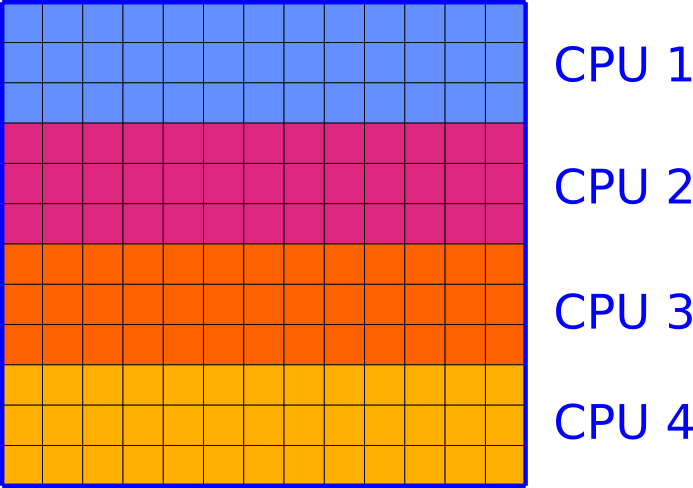
</div>

### Load imbalance

Each CPU will be on charge of updating the entries stored locally. However, this algorithm is a bit different than the previous ones. At iteration $k$ only a subset of the entries in the matrix `B` are updated, i.e. only the entries in the bottom right block  `B[k:end,k:end]` are updated. This block is illustrated in a darker color in the next figure for $k=6$. 

<div>
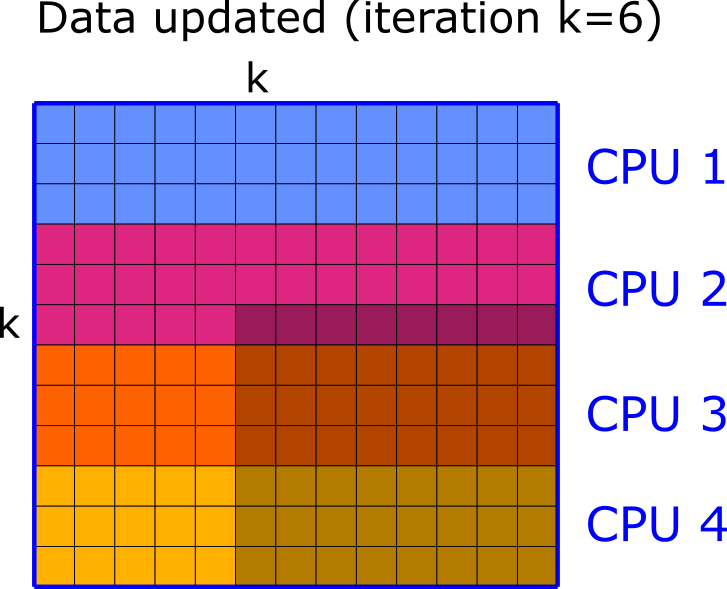
</div>

In this particular example CPU 1 will not have any work to do at iteration $k=6$ and it will be waiting, while other CPUs are computing. In general, CPUs containing rows previous to row $k$ will have less work to do than CPUs containing rows after row $k$. This will worsen as the value of $k$ increases. At some point, only the last CPU will have work to do and the others will idle. 

<div class="alert alert-block alert-info">
<b>Definition:</b> *Load imbalance*: is the problem when work is not equally distributed over all processes and consequently some processes do more work than others.
</div>

Having processors waiting for others is a wast of computational resources and affects negatively parallel speedups. The optimal speedup (speedup equal to the number of processors) assumes that the work is perfectly parallel and that it is evenly distributed. If there is load imbalance, the last assumption is not true anymore and the speedup will be suboptimal.


### Fixing load imbalance

In this application is relatively easy to fix the load imbalance problem. We know in advance which data is going to be processes at each CPU and we can design a more clever data partition.

We can consider row-wise cyclic partition to fix the problem. See figure below. In this case, the CPUs will have less work as the value of $k$ increases, but amount of work will be better distributed than with the block partition.

<div>
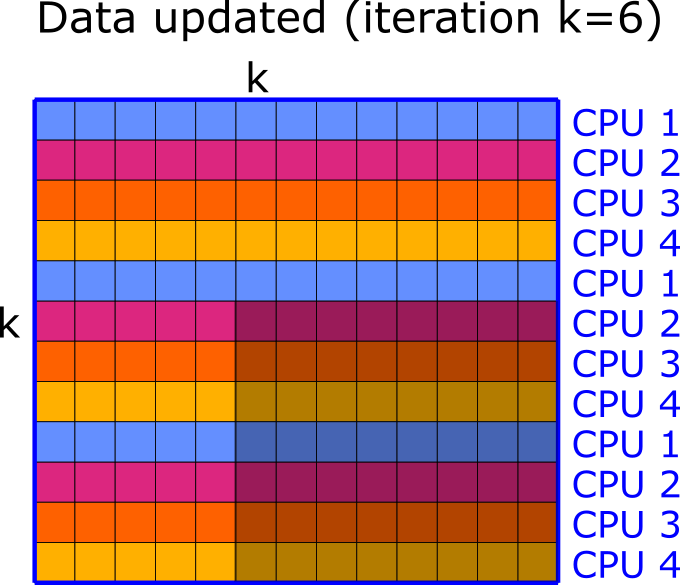
</div>

### Static vs dynamic load balancing

Load balancing is the process of distributing work to processors uniformly with the aim to efficiently exploit a parallel system. There are two key forms of load balancing: Static and dynamic load balancing.

- **Static load balancing**  the work distribution strategy is based on prior information of the algorithm and it does not depend on runtime values.
- **Dynamic load balancing** the work distribution strategy is based on runtime values.

Static load balancing is often used in algorithms for which the load distribution is known in advance and it does not depend on runtime values. On the other hand, dynamic load balancing is often needed in problems in which the work distribution cannot be predicted in advance and depends on runtime values.



<div class="alert alert-block alert-success">
<b>Question:</b>  Using a cyclic partition for Gaussian elimination, is a form of static or dynamic load balancing?
</div>



In [19]:
ge_lb_answer()

It is a form of static load balancing. We know in advance the load distribution and the partition strategy does not depend on the actual values of the input matrix


### Data dependencies

Using a cyclic partition, we managed to distribute the work uniformly. But we still need to study the data dependencies in order to implement it efficiently.

Look again to the algorithm

```julia
n,m = size(B)
for k in 1:n
    for t in k:m
        B[k,t] =  B[k,t]/B[k,k]
    end
    for i in (k+1):n 
        for j in k:m
            B[i,j] = B[i,j] - B[i,k]*B[k,j]
        end
    end
end
```

Note that all updates on the loop over i and j we do the following update 

```julia
B[i,j] = B[i,j] - B[i,k]*B[k,j]
```

As we are using a row-wise partitions, the CPU that updates `B[i,j]` will also have entry `B[i,k]` in memory (both are in the same row). However, `B[k,j]` is in another row and it might be located on another processor. We might need to communicate `B[k,j]` for `j=k:m`. This corresponds to the cells marked in red in the figure below.  These red entries are the data dependencies of this algorithm. The owner of these entries will send them to the other processors. This is very similar to the communications seen in previous notebook for Floyd's algorithm. There is a key difference however, in the current case we do not need to send the full row, only the entries beyond column $k$ (the red cells in the figure).


<div>
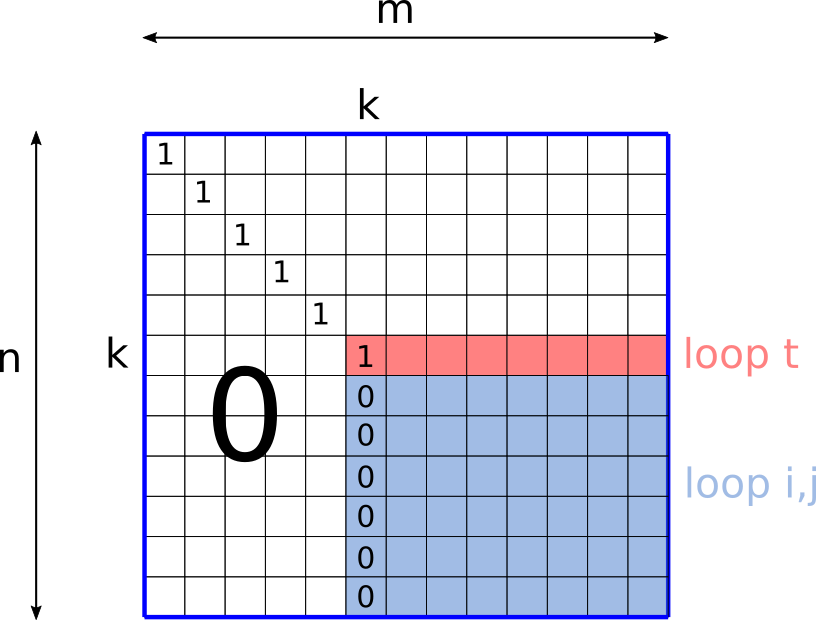
</div>


### Implementation

The parallel implementation of this method is closely related to the Floyd's algorithm. But there are some differences.

At iteration $k$,

1. The CPU owning row $k$ does the loop over $t$ to update row $k$
2. This CPU sends the 

The computation of the complexity of computation and communication is left as an exercise.


1. **Block-wise row partitioning**: Each processor gets a block of subsequent rows. 
2. **Cyclic row partitioning**: The rows are alternately assigned to different processors.

<div>
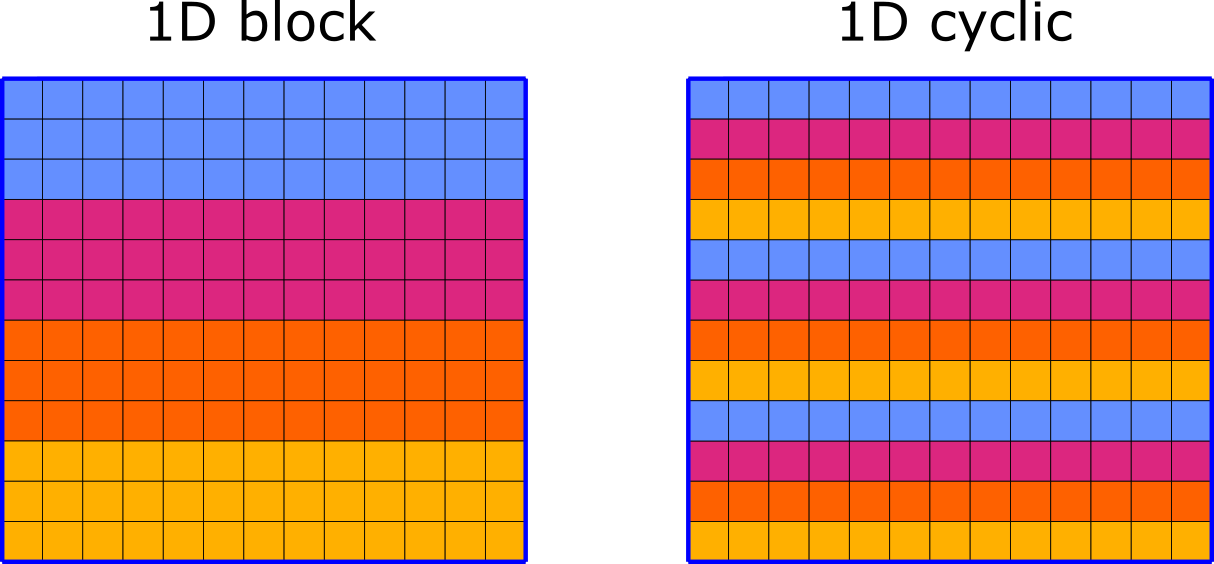
</div>

### Block-wise partition

To evaluate the efficiency of both partitioning schemes, consider how much work the processors do in the following example. 
In any iteration k, which part of the matrix is updated in the inner loops? 

### Block-wise partition

It is clear from the code that at any given iteration `k`, the matrix is updated from row `k` to `n` and from column `k` to `m`. If we look at how that reflects the distribution of work over the processes, we can see that CPU 1 does not have any work, whereas CPU 2 does a little work and CPU 3 and 4 do a lot of work. 

### Load imbalance

The block-wise partitioning scheme leads to load imbalance across the processes: CPUs with rows $<k$ are idle during any iteration $k$. The bad load balance leads to bad speedups, as some CPUs are waiting instead of doing useful work. 
                    
### Data dependencies
                    



<div>
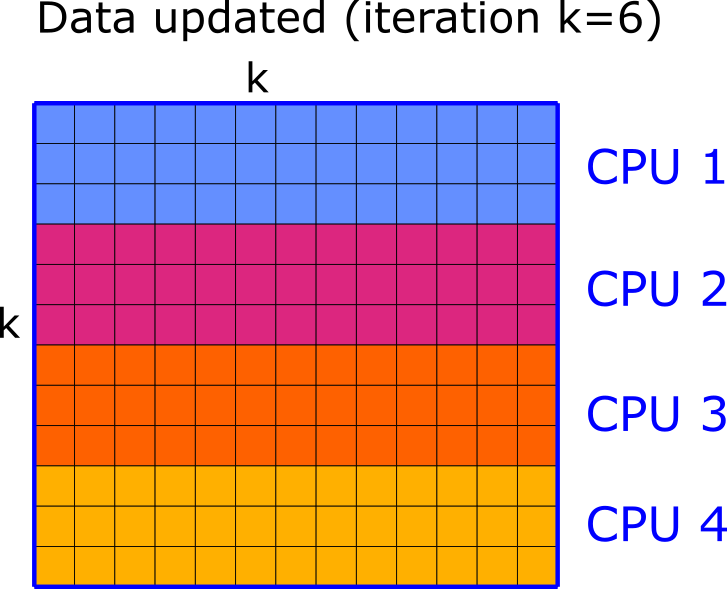
</div>

In [ ]:
answer = "x" # replace x with a, b, c, or d 
ge_dep_check(answer)

## Conclusion
Cyclic partitioning tends to work well in problems with predictable load imbalance. It is a form of **static load balancing** which means using a pre-defined load schedule based on prior information about the algorithm (as opposed to **dynamic load balancing** which can schedule loads flexibly during runtime). The data dependencies are the same as for the 1d block partitioning.

At the same time, cyclic partitioning is not suitable for all communication patterns. For example, it can lead to a large communication overhead in the parallel Jacobi method, since the computation of each value depends on its neighbouring elements.

## Exercise
The actual implementation of the parallel algorithm is left as an exercise. Implement both 1d block and 1d cyclic partitioning and compare their performance. The implementation is closely related to that of Floyd's algorithm. To test your algorithms, generate input matrices with the function below (a random matrix is not enough, we need a non singular matrix that does not require pivoting). 

In [ ]:
function tridiagonal_matrix(n)
    C = zeros(n,n)
    stencil = [(-1,2,-1),(-1,0,1)]
    for i in 1:n
        for  (coeff,o) in zip((-1,2,-1),(-1,0,1))
            j = i+o
            if j in 1:n
                C[i,j] = coeff
            end
        end
    end
    C
end

In [ ]:
n = 12
C = tridiagonal_matrix(n)
b = ones(n)
B = [C b]
gaussian_elimination!(B)

# License



This notebook is part of the course [Programming Large Scale Parallel Systems](https://www.francescverdugo.com/XM_40017) at Vrije Universiteit Amsterdam and may be used under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.